# FMCW Radar Resolution (broken code)

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/matt-chv/mmWrt/blob/main/docs/Resolution.ipynb)

## The problem

Definition of resolution can vary in industries. For radar systems and most contactless distance measurements systems, resolution refers to the ability to resolve two distincts objects apart from each other.


## The solution

Experimenting with FFT to distinguish two targets apart from each other.


In [ ]:
# Install a pip package in the current Jupyter kernel
# Recommended when running from Google Colab or similar environment
import sys
!{sys.executable} -m pip install mmWrt


In [1]:
from os.path import abspath, join, pardir
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors
from numpy import arange, where, expand_dims

# uncomment below if the notebook is launched from project's root folder
# dp = abspath(join(".",pardir))
# sys.path.insert(0, dp)


from mmWrt.Raytracing import rt_points  # noqa: E402
from mmWrt.Scene import Radar, Transmitter, Receiver, Target  # noqa: E402
from mmWrt import RadarSignalProcessing as rsp  # noqa: E402

### Two targets which can be separated

synthetic targets [(2, 0, 0), (3, 0, 0)]
found targets [(1.9617706237424548, 0, 0)]
error is 3.0382293762575454


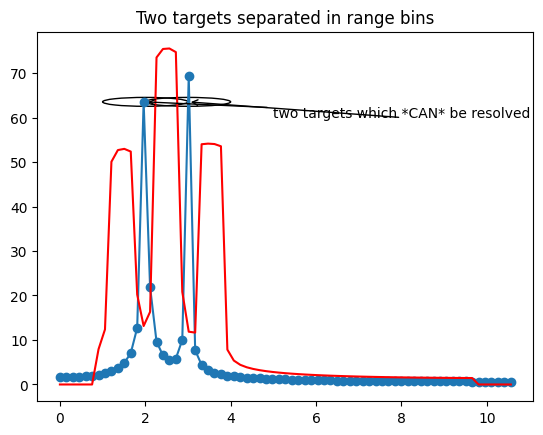

In [7]:
c = 3e8

debug_ON = True
test = 0
radar = Radar(transmitter=Transmitter(bw=1e9, slope=70e8, chirps_count=64),
              receiver=Receiver(fs=1e3, max_adc_buffer_size=256,
                                debug=debug_ON), debug=debug_ON)

target1 = Target(2)
target2 = Target(3, 0, 0, vx=lambda t: 2*t+0)

targets = [target1, target2]

bb = rt_points(radar, targets, debug=debug_ON)

Distances, range_profile = rsp.range_fft(bb)
ca_cfar = rsp.cfar_ca_1d(range_profile)

mag_r = abs(range_profile)
mag_c = abs(ca_cfar)
# little hack to remove small FFT ripples : mag_r> 5
target_filter = ((mag_r > mag_c) & (mag_r > 5))

index_peaks = where(target_filter)[0]
grouped_peaks = rsp.peak_grouping_1d(index_peaks, mag_r)

found_targets = [Target(Distances[i]) for i in grouped_peaks]
error = rsp.error([target1, target2], found_targets)
print("synthetic targets", [t.pos() for t in targets])
print("found targets", [t.pos() for t in found_targets])
print("error is", error)

# 2D representation of the FFT and CFAR
# plot on X,Y axis the FFT and CFAR
figure, axes = plt.subplots()
plt.plot(Distances, mag_r, '-o')
plt.plot(Distances, mag_c, '-r')
plt.title("Two targets separated in range bins")

# Add illustration of target separation
circle1_xy = (target1.x, mag_r[grouped_peaks[0]])
circle_1 = plt.Circle( circle1_xy, 1, fill=False)
circle2_xy = (target2.x, mag_r[grouped_peaks[0]])
circle_2 = plt.Circle( circle2_xy, 1, fill=False)

axes.add_artist(circle_1)
axes.add_artist(circle_2)
plt.annotate("two targets which *CAN* be resolved", xy=circle1_xy, xytext=(8,60),
             horizontalalignment="center",
             # Custom arrow
             arrowprops=dict(arrowstyle='->',lw=1)
             )

plt.annotate("", xy=circle2_xy,xytext=(8,60),
             horizontalalignment="center",
             # Custom arrow
             arrowprops=dict(arrowstyle='->',lw=1)
             )

plt.show()

### Two targets which cannot be separated

(2048,)
tc gc 640.0 128.0
(156,)
synthetic targets [(2, 0, 0), (2.1, 0, 0)]
found targets [(37.12273641851107, 0, 0), (37.27364185110664, 0, 0), (37.42454728370221, 0, 0), (37.57545271629779, 0, 0), (37.72635814889336, 0, 0), (37.87726358148893, 0, 0), (38.028169014084504, 0, 0), (38.17907444668008, 0, 0), (38.329979879275655, 0, 0), (38.480885311871226, 0, 0), (40.89537223340041, 0, 0), (41.04627766599597, 0, 0), (41.19718309859155, 0, 0), (41.34808853118712, 0, 0), (41.498993963782695, 0, 0), (41.64989939637827, 0, 0), (41.800804828973845, 0, 0), (41.95171026156942, 0, 0), (42.10261569416499, 0, 0), (42.25352112676056, 0, 0), (42.40442655935614, 0, 0), (42.55533199195171, 0, 0), (42.70623742454728, 0, 0), (42.857142857142854, 0, 0), (43.00804828973843, 0, 0), (43.158953722334005, 0, 0), (43.309859154929576, 0, 0), (44.81891348088531, 0, 0), (44.969818913480886, 0, 0), (45.12072434607646, 0, 0), (45.27162977867203, 0, 0), (45.42253521126761, 0, 0), (45.57344064386319, 0, 0), (45.72434

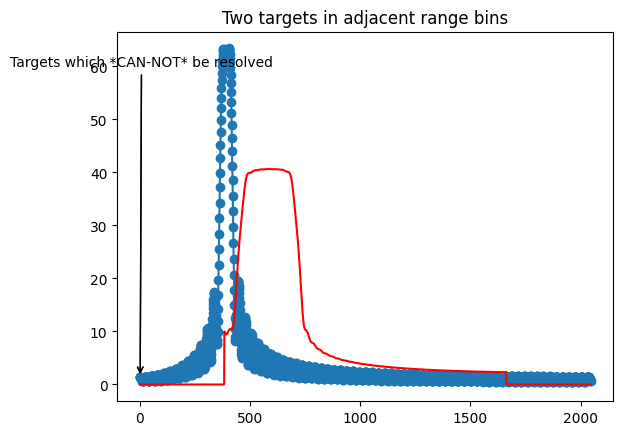

In [53]:
c = 3e8

debug_ON = True
test = 0
radar = Radar(transmitter=Transmitter(bw=1e9, slope=70e8, chirps_count=64),
              receiver=Receiver(fs=1e3, max_adc_buffer_size=256,
                                debug=debug_ON), debug=debug_ON)

target1 = Target(2)
target2 = Target(2.1, 0, 0, vx=lambda t: 2*t+0)

targets = [target1, target2]

bb = rt_points(radar, targets, debug=debug_ON)

prev = 64
fft_pad = 4096
Distances, range_profile = rsp.range_fft(bb, fft_padding=fft_pad)
print(range_profile.shape)
tc = 10*fft_pad/prev
gc = 2*fft_pad/prev
print("tc gc",tc,gc)
ca_cfar = rsp.cfar_ca_1d(range_profile, 
                         count_train_cells=tc, 
                         count_guard_cells=gc)

mag_r = abs(range_profile)
mag_c = abs(ca_cfar)
# little hack to remove small FFT ripples : mag_r> 5
target_filter = ((mag_r > mag_c) & (mag_r > 5))

index_peaks = where(target_filter)[0]
print(index_peaks.shape)
grouping = False
if grouping:
    grouped_peaks = rsp.peak_grouping_1d(index_peaks)
    found_targets = [Target(Distances[i]) for i in grouped_peaks]
else:
    found_targets = [Target(Distances[i]) for i in index_peaks]
error = rsp.error([target1, target2], found_targets)
print("synthetic targets", [t.pos() for t in targets])
print("found targets", [t.pos() for t in found_targets])
print("error is", error)

# 2D representation of the FFT and CFAR
# plot on X,Y axis the FFT and CFAR

figure, axes = plt.subplots()
m, M = 100000-20000, 100000+20000
m, M = 0, -1
R = range(len(mag_r))
plt.plot(R[m:M], mag_r[m:M], 'o-')
plt.plot(R[m:M], mag_c[m:M], 'r-')
plt.title("Two targets in adjacent range bins")

# Add illustration of spectral leakage
circle1_xy = (target1.x, mag_r[grouped_peaks[0]])
circle_1 = plt.Circle( circle1_xy, 1, fill=False)
circle2_xy = (target2.x, mag_r[grouped_peaks[0]+1])
circle_2 = plt.Circle( circle2_xy, 1, fill=False)

axes.add_artist(circle_1)
axes.add_artist(circle_2)
plt.annotate("Targets which *CAN-NOT* be resolved", xy=circle1_xy,
             xytext=(8,60),
             horizontalalignment="center",
             # Custom arrow
             arrowprops=dict(arrowstyle='->',lw=1)
             )

plt.annotate("                                   ", xy=circle2_xy,
             xytext=(8,60),
             horizontalalignment="center",
             # Custom arrow
             arrowprops=dict(arrowstyle='->',lw=1)
             )

plt.show()